### Importing standard libraries

In [1]:
#Author : Digbalay Bose
#importing all the standard packages (numpy, torch, torchvision)
import matplotlib.pyplot as plt
import numpy as np

#torch,torchvision, torchvision transforms
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize (inverse operation of normalization transform)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Setting up tensorboard


In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_run')

### List of transforms to be applied to the dataset

In [4]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

### Declaring the mnist train and test datasets

In [5]:
# acquiring the mnist datasets
dataset = torchvision.datasets.MNIST('../../../../discussion_pytorch/data',
    download=True,
    train=True,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.MNIST('../../../../discussion_pytorch/data',
    download=True,
    train=False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder

split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])

### Declaring the train and validation dataloaders

In [6]:
# dataloaders
#shuffle enabled as True for the train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True)

#shuffle enabled as False for the valid dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False) 

#shuffle enabled as False for the valid dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False) 


### Checking the number of training and testing images

In [7]:
num_train_samples=len(trainset)
print(num_train_samples)
num_val_samples=len(valset)
print(num_val_samples)
num_test_samples=len(testset)
print(num_test_samples)

48000
12000
10000


### Check batches from dataloader

In [8]:
inputs,labels=next(iter(trainloader)) #generate a single batch from trainloader 
print(len(trainloader)) #number of batches 

750


### Inspect the input images generated from dataloader

In [9]:
print(inputs.size())

torch.Size([64, 1, 28, 28])


### Use tensorboard for displaying the images 

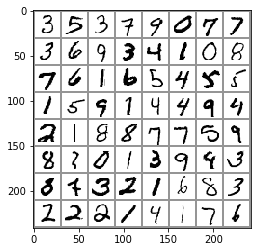

In [10]:
# create grid of images
img_grid = torchvision.utils.make_grid(inputs)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_mnist_images', img_grid)

### Network architecture

In [11]:
#Declaring the network architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #linear layers for first branch 
        self.linear_1_1=nn.Linear(728,64)
        self.linear_1_2=nn.Linear(64,54)
        
        #linear layers for second branch
        self.linear_2_1=nn.Linear(56,10)
        
        #combined linear layer
        self.linear_2=nn.Linear(64,10)
        
    def forward(self,x):
        #x is a single batch (batch_size,28,28,1)
        x=x.squeeze(1)
        x=x.view(-1,28*28) #batch_size * 784
        
        x_1=x[:,:-56] #extracting the first 728 dimensions from the batch (input for one branch) (batch_Size x 728)
        x_2=x[:,-56:]# extracting the last 56 dimensions from the batch (input for another branch) (batch_size x 56)
        
        #first branch forward pass 
        x_1=self.linear_1_1(x_1)
        x_1=F.relu(x_1)
        x_1=self.linear_1_2(x_1)
        x_1=F.relu(x_1) #batch_size x 54
        
        #second branch forward pass  
        x_2=self.linear_2_1(x_2) #batch_size x 10
        x_2=F.relu(x_2)
        
        #concatenate first and second branch outputs
        x_merge=torch.cat([x_1,x_2],dim=1) #batch_size x 64
        x=self.linear_2(x_merge)
        return(x)

In [12]:
net=Net()

### Adding model to tensorboard

In [13]:
writer.add_graph(net, inputs)
writer.close()

### Device selection

In [14]:
### Device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Usage of torchsummary

In [15]:
from torchsummary import summary
net=net.to(device)
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          46,656
            Linear-2                   [-1, 54]           3,510
            Linear-3                   [-1, 10]             570
            Linear-4                   [-1, 10]             650
Total params: 51,386
Trainable params: 51,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


### Testing function

In [16]:
#defining the test/validation loop here 

def eval_model(model,loader,criterion,device):
    """model: instance of model class 
       loader: test dataloader
       criterion: loss function
       device: CPU/GPU
    """
    model.eval() #needed to run the model in eval mode to freeze all the layers
    correct=0
    total=0
    total_loss=0
    with torch.no_grad():
        total=0
        correct=0
        for idx,(inputs,labels) in enumerate(loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            outputs=F.softmax(outputs,dim=1)
            val_loss=criterion(outputs,labels)
            total_loss=total_loss+val_loss
            preds=torch.max(outputs,dim=1)[1]
            
            correct=correct+(preds==labels).cpu().sum().numpy() 
            total=total+len(labels)
    Accuracy=100*(correct/total)
    fin_loss=total_loss/(len(loader))
    
    return(Accuracy,fin_loss)

### Loss function and optimizer definition

In [17]:
#defining loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Main training loop

In [18]:
num_epochs=5

train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
best_val_acc=0

for i in np.arange(num_epochs):
    train_loss=0.0
    correct=0
    for idx,(inputs,labels) in enumerate(trainloader):
        #sending inputs and labels to device 
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        #zero out the gradients to avoid any accumulation during backprop
        optimizer.zero_grad()
        
        #forward pass through the network
        outputs = net(inputs)
        
        #compute the loss between ground truth labels and outputs
        loss = criterion(outputs, labels)
        
        
        loss.backward()#computes derivative of loss for every variable (gradients)
        optimizer.step()#optimizer updates based on gradients 
        
        preds=torch.max(outputs,dim=1)[1] # obtaining the predicted class (dimension of outputs is batch_size x number of classes)
        correct=correct+(preds==labels).cpu().sum().numpy() #.cpu() transfers tensors from GPU to CPU
        train_loss=train_loss+loss.item()
        
    train_loss=train_loss/len(trainloader)#computing the total loss for the entire training set
    train_accuracy=100*(correct/len(trainloader.dataset)) #train accuracy for the dataset
    val_accuracy,val_loss=eval_model(net,valloader,criterion,device) #validation accuracy, validation loss for the entire validation set 
    
    writer.add_scalar('training loss',
                            train_loss,i+1)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    net.train(True)
    print('Epoch:%d,Train Loss:%f,Training Accuracy:%f,Validation Accuracy:%f'%(i+1,train_loss,train_accuracy,val_accuracy))
    if(val_accuracy > best_val_acc):
        print('Saving the best model')
        best_val_acc=val_accuracy
        torch.save({
            'epoch': i+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss}, 'mnist_best_model.pth') #saving all the required information in .pth file (required for restarting models later)
writer.close()

Epoch:1,Train Loss:0.465391,Training Accuracy:86.237500,Validation Accuracy:90.691667
Saving the best model
Epoch:2,Train Loss:0.242870,Training Accuracy:92.875000,Validation Accuracy:93.216667
Saving the best model
Epoch:3,Train Loss:0.176897,Training Accuracy:94.739583,Validation Accuracy:94.775000
Saving the best model
Epoch:4,Train Loss:0.145944,Training Accuracy:95.602083,Validation Accuracy:95.050000
Saving the best model
Epoch:5,Train Loss:0.119355,Training Accuracy:96.347917,Validation Accuracy:95.716667
Saving the best model
Epoch:6,Train Loss:0.106439,Training Accuracy:96.714583,Validation Accuracy:95.525000
Epoch:7,Train Loss:0.094633,Training Accuracy:97.077083,Validation Accuracy:96.408333
Saving the best model
Epoch:8,Train Loss:0.084036,Training Accuracy:97.383333,Validation Accuracy:96.058333
Epoch:9,Train Loss:0.074887,Training Accuracy:97.666667,Validation Accuracy:96.416667
Saving the best model
Epoch:10,Train Loss:0.072890,Training Accuracy:97.664583,Validation Accu

### Plot the training and test performance

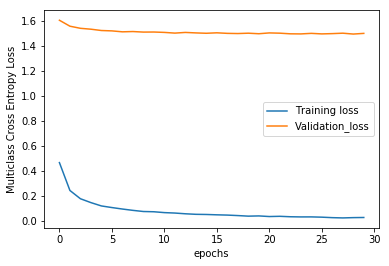

In [22]:
plt.figure()
plt.plot(np.arange(num_epochs), train_loss_list, label='Training loss')
plt.plot(np.arange(num_epochs), val_loss_list, label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.legend()
plt.show()

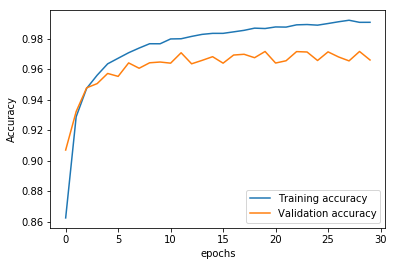

In [23]:
plt.figure()
plt.plot(np.arange(num_epochs), np.array(train_acc_list)/100, label='Training accuracy')
plt.plot(np.arange(num_epochs), np.array(val_acc_list)/100, label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Saving trained models

In [24]:
#saving the entire model 
torch.save(net,'mnist_model.pth')

### Loading saved models

In [25]:
### loading the saved entire model 
mnist_model_total=torch.load('mnist_model.pth')

### loading the saved model with state dict 

mnist_best_model=Net() #declare the model class 
checkpoint=torch.load('mnist_best_model.pth')
mnist_best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Running inference with the saved models 

In [26]:
##inference with the saved entire model 
mnist_model_total.eval()
test_accuracy_total,test_loss_total=eval_model(mnist_model_total,testloader,criterion,device)
print('Test accuracy using the entire saved model:%f' %(test_accuracy_total))
print('Test loss using the entire saved model:%f' %(test_loss_total))

##inference with the model loaded from state dict
mnist_best_model.eval()
test_accuracy_best,test_loss_best=eval_model(mnist_best_model,testloader,criterion,device)
print('Test accuracy using the entire saved model:%f' %(test_accuracy_best))
print('Test loss using the entire saved model:%f' %(test_loss_best))

Test accuracy using the entire saved model:96.760000
Test loss using the entire saved model:1.496011
Test accuracy using the entire saved model:97.240000
Test loss using the entire saved model:1.492690
